# Data Acquisition

In [13]:
import os
import urllib
import zipfile
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [14]:
zip_target_folder = "energy-prediction"
!mkdir -p $zip_target_folder

In [15]:
zip_filepath = "energy-prediction.zip"

url_path = "https://archive.ics.uci.edu/static/public/994/micro+gas+turbine+electrical+energy+prediction.zip"
urllib.request.urlretrieve(url_path, zip_filepath)

with zipfile.ZipFile(zip_filepath, "r") as zip_ref:
    zip_ref.extractall(zip_target_folder)

In [16]:
!ls $zip_target_folder

test.zip  train.zip


In [17]:
dataset_part_names = ["train", "test"]

for part_name in dataset_part_names:
    part_target_folder = f"{zip_target_folder}/{part_name}"
    part_zip_path = f"{part_target_folder}.zip"

    with zipfile.ZipFile(part_zip_path, "r") as zip_ref:
        zip_ref.extractall(part_target_folder)

In [18]:
!ls $zip_target_folder

test  test.zip	train  train.zip


In [19]:
!ls -R $zip_target_folder/

energy-prediction/:
test  test.zip	train  train.zip

energy-prediction/test:
test

energy-prediction/test/test:
ex_22.csv  ex_4.csv

energy-prediction/train:
train

energy-prediction/train/train:
ex_1.csv  ex_20.csv  ex_21.csv	ex_23.csv  ex_24.csv  ex_9.csv


In [20]:
!wc -l energy-prediction/train/train/*

   9921 energy-prediction/train/train/ex_1.csv
   6496 energy-prediction/train/train/ex_20.csv
   6496 energy-prediction/train/train/ex_21.csv
   9189 energy-prediction/train/train/ex_23.csv
   9024 energy-prediction/train/train/ex_24.csv
  11820 energy-prediction/train/train/ex_9.csv
  52946 total


In [21]:
train_data_folderpath = f"{zip_target_folder}/train/train/"
test_data_folderpath = f"{zip_target_folder}/test/test/"

In [22]:
reader_properties = {
    # "separator": ";",
    # "decimal_comma": True,
    # "infer_schema_length": 10000
    "infer_schema": False
}


def load_experiment_df(experiment_file_path):
    experiment_df = pl.read_csv(experiment_file_path, **reader_properties).with_columns(
        pl.col("time").str.to_decimal().cast(pl.Int64),
        pl.col("input_voltage").str.to_decimal().cast(pl.Float64),
        pl.col("el_power").str.to_decimal().cast(pl.Float64)
    )

    return experiment_df

In [ ]:
# def load_experiment_df_from_folder(folder_path):
#     df = None

#     for experiment_file_name in os.listdir(folder_path):
#         experiment_file_path = f"{folder_path}/{experiment_file_name}"

#         experiment_df = load_experiment_df(experiment_file_path)
#         if df is None:
#             df = experiment_df
#         else:
#             df = df.vstack(experiment_df)
#     return df

In [ ]:
# df = load_experiment_df_from_folder(train_data_folderpath)

# print("Dataset size:", len(df))

# df.head()

Dataset size: 3708


time,input_voltage,el_power
i64,f64,f64
840,3.0,9089.797969
855,3.0,17004.530009
870,3.0,16086.932648
885,3.0,17133.911283
900,3.0,17126.525165


# Data Preprocessing & Representation

In [ ]:
# df = df.drop_nulls()

# df.shape

In [4]:
def downscale_experiment_df_frequency(experiment_df, downscaling_frequency):
    return experiment_df.group_by_dynamic("time", every=downscaling_frequency).agg(
        pl.mean("input_voltage"),
        pl.col("el_power").sum(),
    )

In [24]:
def create_forecasting_sets(data: pl.DataFrame, target_name: str, exog: list[str], context_window_size: int, forecast_horizon: int):
    data_size = len(data)
    unit_window_size = context_window_size + forecast_horizon
    features_cols_names = exog + [target_name]

    x, y = [], []

    for i in range(data_size - unit_window_size + 1):
        forecast_start_idx = i + context_window_size
        forecast_stop_idx = forecast_start_idx + forecast_horizon

        seq_prev_data = data[i:forecast_start_idx, target_name].to_list()
        exog_data = list(data[forecast_start_idx, exog].row(0))
        x.append(seq_prev_data + exog_data)

        prediction = data[forecast_start_idx:forecast_stop_idx, target_name]
        y.append(prediction)

    return (np.array(x), np.array(y))

In [30]:
def load_dataset_from_experiment(experiment_filepath, downscaling_frequency, context_window_size, forecast_horizon):
    df = load_experiment_df(experiment_filepath)
    downscaled_df = downscale_experiment_df_frequency(df, downscaling_frequency)
    X, y = create_forecasting_sets(downscaled_df, "el_power", ["input_voltage"], context_window_size, forecast_horizon)
    return X, y

In [31]:
def load_dataset_from_folder(folder_path, downscaling_frequency, context_window_size, forecast_horizon):
    X, y = None, None
    for experiment_file_name in os.listdir(folder_path):
        experiment_file_path = f"{folder_path}/{experiment_file_name}"

        experiment_X, experiment_y = load_dataset_from_experiment(experiment_file_path, downscaling_frequency, context_window_size, forecast_horizon)
        if X is None:
            X, y = experiment_X, experiment_y
        else:
            X = np.vstack((X, experiment_X))
            y = np.vstack((y, experiment_y))
    return X, y

In [6]:
downscaling_frequency = "15i"

context_window_size = 5
forecast_horizon = 1

In [394]:
X_train, y_train = load_dataset_from_folder(train_data_folderpath, downscaling_frequency, context_window_size, forecast_horizon)

X_train.shape, y_train.shape

((3678, 6), (3678, 1))

In [395]:
X_train[:5]

array([[1.88845441e+04, 1.98418941e+04, 2.09217027e+04, 2.21391560e+04,
        2.32277726e+04, 1.00000000e+01],
       [1.98418941e+04, 2.09217027e+04, 2.21391560e+04, 2.32277726e+04,
        2.61478017e+04, 1.00000000e+01],
       [2.09217027e+04, 2.21391560e+04, 2.32277726e+04, 2.61478017e+04,
        2.58263513e+04, 1.00000000e+01],
       [2.21391560e+04, 2.32277726e+04, 2.61478017e+04, 2.58263513e+04,
        2.71533570e+04, 1.00000000e+01],
       [2.32277726e+04, 2.61478017e+04, 2.58263513e+04, 2.71533570e+04,
        2.84522433e+04, 1.00000000e+01]])

In [396]:
y_train[:5]

array([[26147.80167252],
       [25826.35129703],
       [27153.35704515],
       [28452.24329053],
       [29588.37127558]])

In [397]:
scaler = MinMaxScaler()

# Scale `el_power` values
scaled_y_train = scaler.fit_transform(y_train)
scaled_X_train = X_train.copy()
for col in range(context_window_size):
    scaled_X_train[:, col] = scaler.transform(X_train[:, col].reshape(-1, 1)).squeeze()

scaled_X_train.shape, scaled_y_train.shape

((3678, 6), (3678, 1))

In [398]:
scaled_X_train[:5]

array([[ 0.31072447,  0.33144723,  0.35482071,  0.38117365,  0.40473779,
        10.        ],
       [ 0.33144723,  0.35482071,  0.38117365,  0.40473779,  0.46794461,
        10.        ],
       [ 0.35482071,  0.38117365,  0.40473779,  0.46794461,  0.46098651,
        10.        ],
       [ 0.38117365,  0.40473779,  0.46794461,  0.46098651,  0.48971081,
        10.        ],
       [ 0.40473779,  0.46794461,  0.46098651,  0.48971081,  0.51782644,
        10.        ]])

In [399]:
scaled_y_train[:5]

array([[0.46794461],
       [0.46098651],
       [0.48971081],
       [0.51782644],
       [0.54241902]])

In [400]:
def scale_dataset(X, y, n_X_vars):
    scaled_y = scaler.transform(y)
    scaled_X = X.copy()
    for col in range(n_X_vars):
        scaled_X[:, col] = scaler.transform(X[:, col].reshape(-1, 1)).squeeze()

    return scaled_X, scaled_y

In [401]:
test_experiment_file_path = f"{test_data_folderpath}/ex_22.csv"
X_test, y_test = load_dataset_from_experiment(test_experiment_file_path, downscaling_frequency, context_window_size, forecast_horizon)

# Scale `el_power` values
scaled_X_test, scaled_y_test = scale_dataset(X_test, y_test, context_window_size)

scaled_X_test.shape, scaled_y_test.shape

((633, 6), (633, 1))

In [402]:
scaled_X_test[:5]

array([[0.02648486, 0.27014493, 0.27219511, 0.24898919, 0.27462564,
        3.        ],
       [0.27014493, 0.27219511, 0.24898919, 0.27462564, 0.27641163,
        3.        ],
       [0.27219511, 0.24898919, 0.27462564, 0.27641163, 0.25191617,
        3.        ],
       [0.24898919, 0.27462564, 0.27641163, 0.25191617, 0.27300057,
        3.        ],
       [0.27462564, 0.27641163, 0.25191617, 0.27300057, 0.27390302,
        3.        ]])

In [403]:
scaled_y_test[:5]

array([[0.27641163],
       [0.25191617],
       [0.27300057],
       [0.27390302],
       [0.27412916]])

# Modelization

In [404]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, LSTM

In [414]:
n_features = scaled_X_train.shape[1]
lstm_n_units = 16

In [423]:
model = Sequential([
    Input((n_features, 1)),
    LSTM(lstm_n_units),
    Dense(forecast_horizon),
])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [424]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

fitting_batch_size = 32
n_epochs = 3
history = model.fit(scaled_X_train, scaled_y_train, epochs=n_epochs, validation_split=0.1, batch_size=fitting_batch_size)

Epoch 1/3
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2890 - mae: 0.4219 - val_loss: 0.0061 - val_mae: 0.0715
Epoch 2/3
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - mae: 0.0828 - val_loss: 0.0018 - val_mae: 0.0358
Epoch 3/3
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - mae: 0.0339 - val_loss: 6.3787e-04 - val_mae: 0.0134


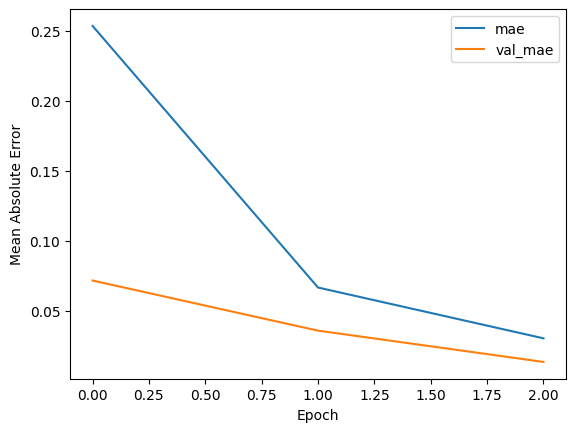

In [425]:
import matplotlib.pyplot as plt

plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.legend(["mae", "val_mae"])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.show()

# Evaluation

In [426]:
loss, mae = model.evaluate(scaled_X_test, scaled_y_test)

print("Evaluation Loss:", loss)
print("Evaluation MAE:", mae)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0292     
Evaluation Loss: 0.002601663349196315
Evaluation MAE: 0.038965895771980286


In [427]:
y_pred = model.predict(scaled_X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [428]:
y_pred.shape

(633, 1)

In [430]:
from sklearn.metrics import r2_score

score = r2_score(scaled_y_test, y_pred)
print("R2 Score:", score)

R2 Score: 0.9267723454072323


(633, 633)


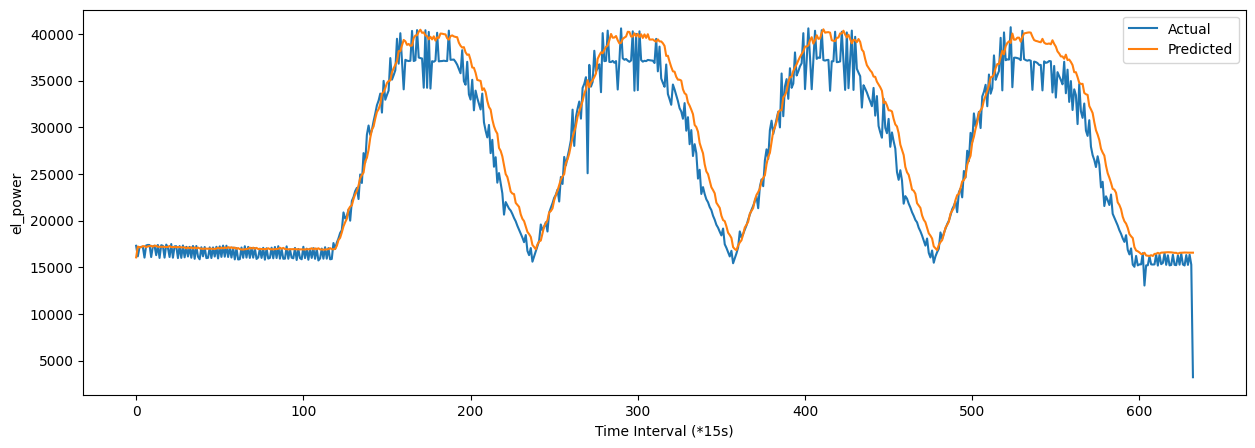

In [434]:
y_pred_inv = scaler.inverse_transform(y_pred).flatten()
y_test_inv = scaler.inverse_transform(scaled_y_test).flatten()

print((len(y_pred_inv), len(y_test_inv)))

plt.figure(figsize=(15,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()

# Model Backup

In [435]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [436]:
backup_folder_path = "/gdrive/MyDrive/ESTIAM/E5/AI-ML-Model-Design/TimeSeries-Forecasting/backup"

In [437]:
!mkdir -p "$backup_folder_path"

In [438]:
scaler_file_path = f"{backup_folder_path}/scaler.joblib"
model_file_path = f"{backup_folder_path}/model.keras"

In [439]:
import joblib

joblib.dump(scaler, scaler_file_path)
model.save(model_file_path)

In [443]:
!ls {backup_folder_path}

model.keras  scaler.joblib


# Model Loading & Manual Testing

## Loading

In [441]:
from tensorflow import keras

loaded_scaler = joblib.load(scaler_file_path)
loaded_model = keras.models.load_model(model_file_path)

In [442]:
loaded_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,509 (13.71 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,340 (9.14 KB)

## Testing

## From file

Setup test data

In [444]:
test_experiment_file_path = f"{test_data_folderpath}/ex_4.csv"
X_test, y_test = load_dataset_from_experiment(test_experiment_file_path, downscaling_frequency, context_window_size, forecast_horizon)

# Scale `el_power` values
scaled_X_test, scaled_y_test = scale_dataset(X_test, y_test, context_window_size)

scaled_X_test.shape, scaled_y_test.shape

((649, 6), (649, 1))

Predict with model

In [445]:
y_pred = loaded_model.predict(scaled_X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Display predicted value

In [446]:
scaled_y_test[:5]

array([[0.30333439],
       [0.302118  ],
       [0.30118621],
       [0.30378112],
       [0.3067994 ]])

In [447]:
y_pred[:5]

array([[0.27101812],
       [0.2932069 ],
       [0.2931998 ],
       [0.29302225],
       [0.29305515]], dtype=float32)

Display unscaled prediction

In [448]:
predicted = scaler.inverse_transform(y_pred).flatten()
predicted[:5].tolist()

[17050.189453125,
 18075.267578125,
 18074.939453125,
 18066.736328125,
 18068.255859375]

(649, 649)


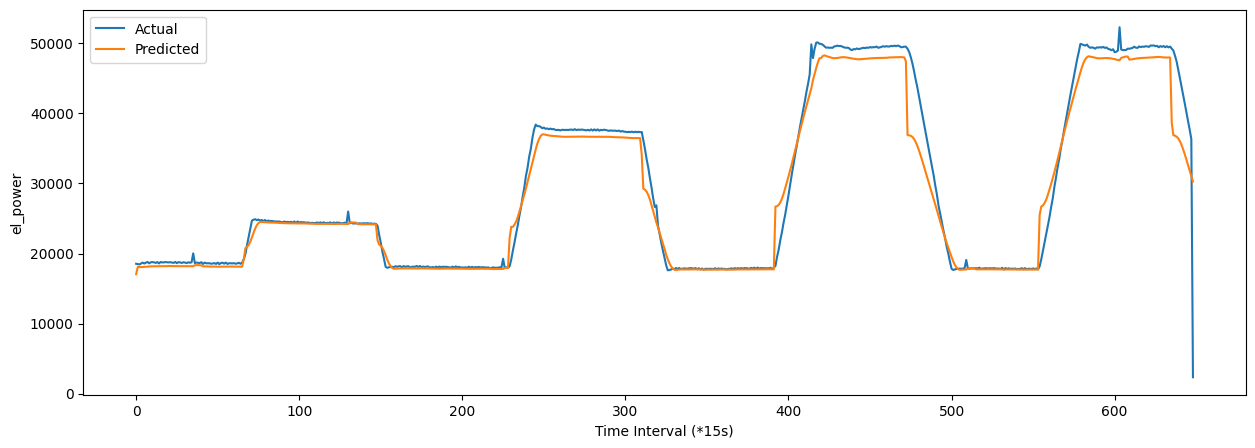

In [449]:
expected = scaler.inverse_transform(scaled_y_test).flatten()

print((len(predicted), len(expected)))

plt.figure(figsize=(15,5))
plt.plot(expected, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()

## Custom data

In [457]:
sample_data = pl.DataFrame(
    [
        (18500, 3),
        (15600, 3),
        (17000, 3),
        (19850, 3),
        (18750, 3),
        (15620, 3),
        (17050, 3),
        (16920, 3),
        (17350, 3),
        (20450, 5),
        (19320, 5),
        (19950, 5),
        (20300, 5),
        (20530, 5),
        (20420, 5),
    ],
    schema={
        "el_power": pl.Float64,
        "input_voltage": pl.Float64,
    },
    orient="row",
)

print("Dataset size:", len(sample_data))

(input, output) = create_forecasting_sets(sample_data, "el_power", ["input_voltage"], context_window_size, forecast_horizon)

scaled_input, _ = scale_dataset(input, output, context_window_size)
y_pred = loaded_model.predict(scaled_input)

Dataset size: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


(10, 10)


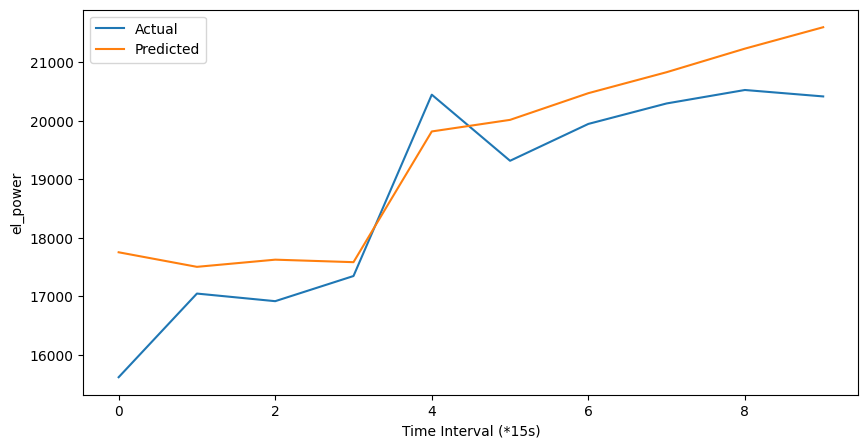

In [460]:
predicted = scaler.inverse_transform(y_pred).flatten()

print((len(predicted), len(output)))

plt.figure(figsize=(10, 5))
plt.plot(output, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Time Interval (*15s)")
plt.ylabel("el_power")
plt.legend()
plt.show()